# Feasibility Analysis in MAGNUS

The module `NSFeas` in `MAGNUS` provides a set of methods to define and solve feasibility problems using nested sampling.  `NSFeas` leverages the DAG evaluation capability in `pyMC` to run the scenario simulations internally. Additionally, capability to embed ordinary differential equations (ODEs) into a DAG can be leveraged from `CRONOS` to enable dynamic feasibility analysis.

## Feasibility Analysis of a Pair of Algebraic Constraints

We consider the following example from [Kusumo _et al_ (2019)](https://doi.org/10.1021/acs.iecr.9b05006) with two design variables, ${\bf d}:=(d_1, d_2)^\intercal$ and a single output, $y$ given by:
$$\begin{align}
y = \theta d_1^2 + d_2
\end{align}$$
with the model parameter $\theta$. Our goal is to characterize the probabilistic feasible set inside the a priori domain $\mathcal{D}_0 \coloneqq [-1, 1]^2$ defined by the following pair of constraints:
$$\begin{equation}
0.20 \leq y \leq 0.75
\end{equation}$$
We want to characterize the nominal case corresponding to $\theta_{\rm nom}=1$::
$$\begin{align}
\mathcal{D}_{\rm nom} \coloneqq \{ {\bf d}\in \mathcal{D}_0: 0.20\leq d_1^2+d_2 \leq 0.75 \}
\end{align}$$
We also want to characterize the probabilistic case under a normality assumption for the model parameters, $\theta \sim \mathcal N(1,\sqrt{3})$:
$$\begin{align}
\mathcal{D}_\alpha \coloneqq  \left\{ {\bf d}\in \mathcal{D}_0: \mathbb{P}\left[0.20\leq \theta d_1^2+d_2 \leq 0.75 \:\middle|\: \theta \sim \mathcal N(1,\sqrt{3}) \right] \geq \alpha \right\}
\end{align}$$
with a feasibility probability $\alpha\geq 0.9$.

We start by importing both the `PyMC`, `CRONOS`, `CANON` and `MAGNUS` modules:

In [1]:
import pymc
from magnus import NSFeas

NSFeas.uniform_sampling( 10, [0,0], [1,1] )


[[0.5, 0.5],
 [0.75, 0.25],
 [0.25, 0.75],
 [0.375, 0.375],
 [0.875, 0.875],
 [0.625, 0.125],
 [0.125, 0.625],
 [0.1875, 0.3125],
 [0.6875, 0.8125],
 [0.9375, 0.0625]]

Next, we define the DAG of the growth model in `pyMC`:

In [2]:
# Create DAG
DAG = pymc.FFGraph()
DAG.options.MAXTHREAD = 1

d = DAG.add_vars( 2, "d" )
p = DAG.add_var( "p" )
#p.set( 1 );
y = p*d[0]**2 + d[1]
print( "y = ", y.str() )

y =  d1 + p * SQR( d0 )


We instantiate an environment `NSFeas` and set the relevant options:

In [3]:
# Instantiate nested sampler
NS = NSFeas()

NS.options.DISPLEVEL = 1
NS.options.FEASCRIT  = NS.options.VAR #CVAR
NS.options.FEASTHRES = 0.05
NS.options.NUMLIVE   = 1000
NS.options.NUMPROP   = 16
NS.options.MAXITER   = 0

NS.set_dag( DAG )
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.set_control( d, [ -1, -1 ], [ 1, 1 ] )

We start with the nominal scenario with $p=1$. After setup, we conduct a nested sampling using the method `sample`:

In [4]:
NS.set_parameter( [p], [1] );
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS
(1000)      0.00 SEC
    0     1.0686e+00   274       16     3.0000e-01
    1     1.0370e+00   277       32     2.9910e-01
    2     9.7069e-01   283       47     2.9815e-01
    3     9.3323e-01   287       62     2.9725e-01
    4     8.8890e-01   293       77     2.9636e-01
    5     8.6403e-01   297       92     2.9547e-01
    6     8.1644e-01   303      104     2.9459e-01
    7     7.9912e-01   307      119     2.9388e-01
    8     7.6195e-01   310      135     2.9300e-01
    9     7.3491e-01   315      150     2.9207e-01
   10     7.1302e-01   320      162     2.9119e-01
   11     6.8961e-01   324      176     2.9049e-01
   12     6.6459e-01   333      192     2.8968e-01
   13     6.3601e-01   338      205     2.8876e-01
   14     6.1226e-01   343      219     2.8801e-01
   15     5.9691e-01   349      232     2.8720e-01
   16     5.8110e-01   353      248     2.8646e-01
   17     5.6822e-01   357      260     2.8554e-01
   18     5.5513e-01   362      2

0

We can retrieve the live points, dead points, or discarded points for plotting from the respective fields `live_points`, `dead_points` and `discard_points`:

In [5]:
print( NS.live_points )

[[-2.74969167e-01 -2.74032593e-01 -2.73721132e-01 ... -3.29864019e-04
  -8.29973502e-05  0.00000000e+00]
 [-3.39153317e-01  1.05468750e-01  2.59338373e-01 ... -4.20118157e-01
   4.58537769e-01 -5.00000000e-01]
 [ 3.60005861e-01  4.64843750e-01  4.09022476e-01 ...  5.73170870e-01
  -1.01738881e-02  5.00000000e-01]]


A plot of the nominal feasible domain is shown below:

In [6]:
import numpy as np
import matplotlib.pyplot as plt

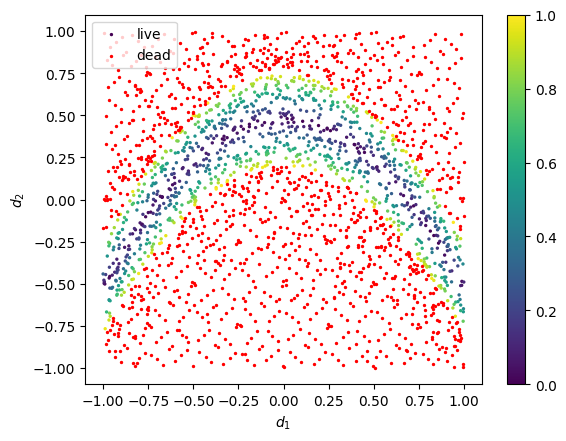

In [7]:
live = NS.live_points
dead = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(live[1,:], live[2,:], c=live[0,:], s=2, cmap='viridis', label='live')
plt.scatter(dead[1,:], dead[2,:], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Next, we consider the probabilistic scenario with 100 samples drawn from $p\sim\mathcal{N}(1,\sqrt{3})$:

In [8]:
np.random.seed( 0 )
psam = []
[ psam.append( [ np.random.normal( 1, np.sqrt(3) ) ] ) for i in range(0,100) ]

NS.set_parameter( [p], psam );
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS
(1000)      0.01 SEC
    0     3.6312e+00    54       16     3.0000e-01
    1     3.3935e+00    54       30     2.9910e-01
    2     3.2085e+00    56       46     2.9827e-01
    3     3.0149e+00    57       62     2.9731e-01
    4     2.9077e+00    57       77     2.9636e-01
    5     2.8517e+00    57       90     2.9547e-01
    6     2.7501e+00    57      104     2.9471e-01
    7     2.6433e+00    58      119     2.9388e-01
    8     2.5799e+00    59      134     2.9300e-01
    9     2.4884e+00    59      149     2.9213e-01
   10     2.4186e+00    59      163     2.9125e-01
   11     2.3344e+00    60      176     2.9044e-01
   12     2.2927e+00    60      190     2.8968e-01
   13     2.2271e+00    61      205     2.8887e-01
   14     2.1880e+00    62      218     2.8801e-01
   15     2.1233e+00    64      232     2.8726e-01
   16     2.0763e+00    65      243     2.8646e-01
   17     2.0180e+00    65      258     2.8583e-01
   18     1.9737e+00    66      2

0

A plot of the probabilistic feasible domain with infeasibility threshold set to 10% is shown below:

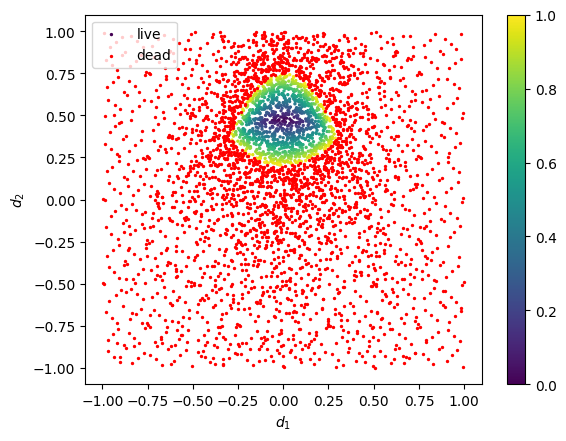

In [9]:
live = NS.live_points
dead = NS.dead_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(live[1,:], live[2,:], c=live[0,:], s=2, cmap='viridis', label='live')
plt.scatter(dead[1,:], dead[2,:], c='r', s=2, label='dead')
plt.colorbar()
plt.legend(loc="best")
plt.show()

Finally, we illustrate how to pass a custom model from python into the DAG to solve the same problem:

In [10]:
def model( x ):
  return [ x[2]*x[0]**2 + x[1] ]

OpY = pymc.FFCustom()
OpY.set_D_eval( model )
y = OpY( d+[p], 0 )
print( "y = ", y.str() )


y =  Custom[0][0]( d0, d1, p )


In [11]:
NS.set_constraint( [ y-0.75, 0.20-y ] )
NS.setup()
NS.sample()

** INITIALIZING LIVE POINTS
(1000)      0.04 SEC
    0     3.6840e+00    54       15     3.0000e-01
    1     3.3821e+00    56       31     2.9916e-01
    2     3.1711e+00    57       46     2.9821e-01
    3     3.0268e+00    58       61     2.9731e-01
    4     2.9122e+00    59       76     2.9642e-01
    5     2.8398e+00    59       90     2.9553e-01
    6     2.7337e+00    61      104     2.9471e-01
    7     2.6501e+00    62      118     2.9388e-01
    8     2.5853e+00    63      133     2.9306e-01
    9     2.5073e+00    65      146     2.9218e-01
   10     2.4364e+00    65      162     2.9142e-01
   11     2.3645e+00    66      174     2.9049e-01
   12     2.3028e+00    67      189     2.8980e-01
   13     2.2686e+00    67      200     2.8893e-01
   14     2.2129e+00    67      215     2.8829e-01
   15     2.1691e+00    69      228     2.8743e-01
   16     2.0904e+00    69      240     2.8668e-01
   17     2.0468e+00    69      251     2.8600e-01
   18     2.0142e+00    70      2

0

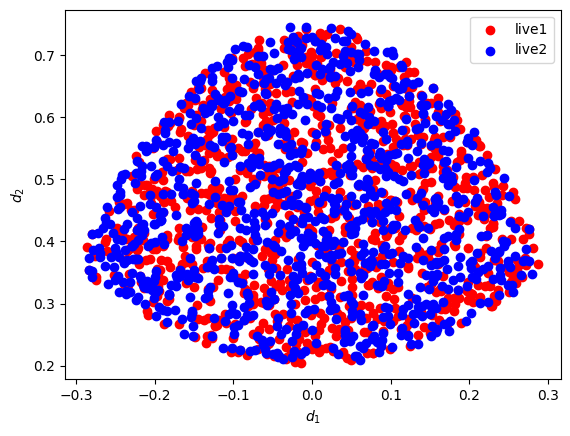

In [12]:
live2= NS.live_points

plt.xlabel("$d_1$")
plt.ylabel("$d_2$")
plt.scatter(live[1,:], live[2,:], c='r', label='live1')
plt.scatter(live2[1,:], live2[2,:], c='b', label='live2')
plt.legend(loc="best")
plt.show()